## Calzada Jasso Andres Geovani *<span style = "color : Blue" > 23265539 </span>*

### **Proyecto** *<span style = "color : #E3182E" >Clasificación de imágenes de tumores por resonancia magnética (MRI) a través de CNN</span>*

Una imagen de MRI es una imagen que se obtiene mediante una técnica de imagen médica llamada resonancia magnética (MRI, por sus siglas en inglés). Esta técnica utiliza campos magnéticos y ondas de radio para generar imágenes detalladas de los órganos y los tejidos del cuerpo, sin usar radiación ionizante. Una imagen de MRI puede mostrar la estructura y la función de diferentes partes del cuerpo, como el cerebro, el corazón, los huesos, las articulaciones y los órganos internos. Una imagen de MRI puede ayudar a diagnosticar diversas enfermedades o anomalías, como tumores, aneurismas, esclerosis múltiple, accidentes cerebrovasculares, inflamación, infecciones, etc.

Así este conjunto de datos de tiene imágenes de tipos de tumores cerebrales, incluidos tumores pituitarios, gliomas, meningiomas o exploraciones sin tumores.


<img src= "https://www.researchgate.net/profile/Jesus-Ramirez-Bermudez/publication/339100445/figure/fig1/AS:863039561674752@1582776074010/Figura-1-Imagen-por-resonancia-magnetica-del-cerebro-a-Cortes-sagital-y-axial-en.jpg">

In [1]:
#Imporamos las librerias 

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import cv2 
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import visualkeras
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report

## Analisis exploratorio 

Para conocer la naturaleza de las imagenes utilizamos el siguiente código el cual nos ayuda para definir la ruta a la carpeta que contiene las imágenes que se usarán para entrenar, que se llama ‘brain_tumor’. Cargamos las imágenes que se usarán para entrenar en una lista llamada images_train, y las etiquetas correspondientes en otra lista llamada labels_train. Las etiquetas son los nombres de las cuatro categorías de tumores: glioma, meningioma, notumor y pituitary. Posteriormente se convierten las imágenes a un formato compatible con TensorFlow, que es un array de NumPy de tipo float32.

Normalizamos los datos de la imagen dividiéndolos por 255, para que los valores estén entre 0 y 1. Para despues definir los nombres de las clases en una lista llamada class_names. Después creamos una variable que sea aleatoria entre los valores de las imágenes para poder representar 25 de ellas al azar, usando la función randint de NumPy. Para finalmente crear una figura de matplotlib con 25 subplots, y muestra una imagen aleatoria en cada uno, con su etiqueta correspondiente.

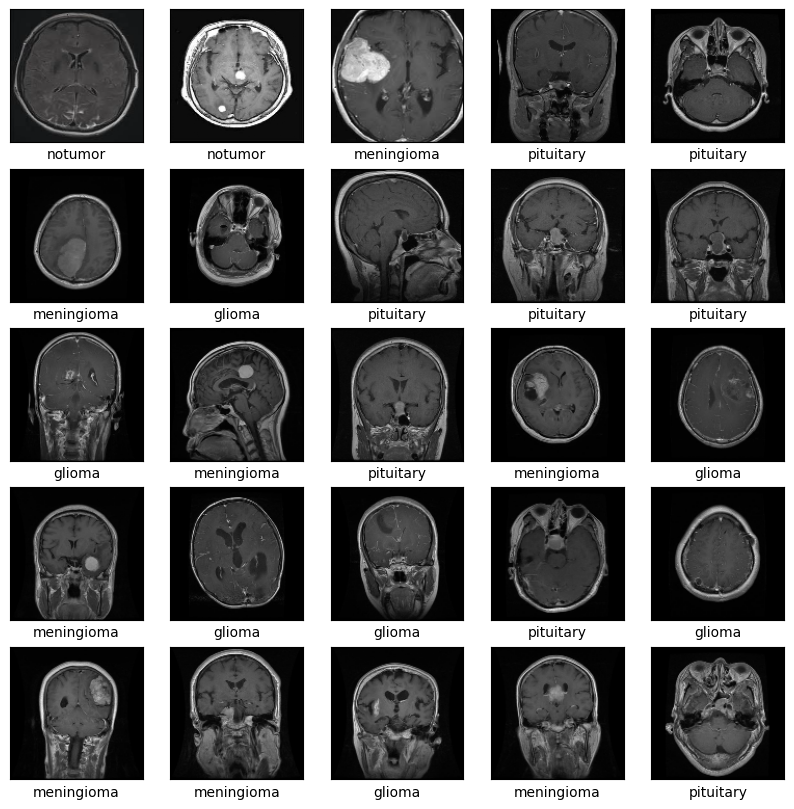

In [2]:
# Definimos la ruta a la carpeta que contiene las imágenes que se usaran para probar
data_train = os.getcwd() + "/brain_tumor"

# Cargamos las imágenes que se usaran para entrenar 
images_train = []
labels_train = []
for category in os.listdir(data_train):
    category_dir = os.path.join(data_train, category)
    for image_file in os.listdir(category_dir):
        image_train = cv2.imread(os.path.join(category_dir, image_file))
        image_train = cv2.resize(image_train, (128, 128))  
        images_train.append(image_train)
        labels_train.append(category)
# Convertimos las imágenes a un formato compatible con TensorFlow
images_train = np.array(images_train)
images_train = images_train.astype(np.float32)


# Normalizamos los datos de la imagen
images_train = images_train / 255.


class_names = ['glioma','meningioma','notumor','pituitary']

#Creamos una variable para que sea aleatoria entre los valores de las imagenes para poder representar 25 de ellas al azar
indexs = randint(0, len(images_train), 25)
indexs

plt.figure(figsize=(10,10))
for i, j in zip(range(25), indexs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[j])
    plt.xlabel(labels_train[j])
plt.show()


#### Generamos un generador de datos de keras para realizar un preprocesamiento de imagenes que realizará lo siguiente.

1. Escala todos los píxeles de las imágenes para que estén entre 0 y 1.
2. Aplica aleatoriamente una transformación de sesgo a las imágenes.
3. Aplica aleatoriamente una transformación de zoom a las imágenes.
4. Divide los datos en un conjunto de entrenamiento y un conjunto de validación. El conjunto de validación es el 20% de los datos.

In [3]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2  #Nos dale 20% de nuestro total de imagenes el cual es 291 imagenes 
)

En esta parte del código encontramos todas nuestras imagenes en la carpeta del dataset, estas estan agrupadas en las clases 'glioma', 'meningioma', 'notumor', 'pituitary'. las cuales consisten en 4 carpetas cada una con 1456 imagenes dando un total de 5824 imagenes categorizadas en las 4 clases mencionada.

In [4]:
data_path = "./brain_tumor"

data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),  #Recibimos las imagenes en 64x64 pixeles
    batch_size=32,         #
    class_mode='categorical',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary'] 
)


Found 5824 images belonging to 4 classes.


Una vez que tenemos la funcion de keras data_generator que nos ayuda a preprocesar las imagenes, vamos a generar nuestro conjunto de entrenamiento y nuestro conjunto de prueba

##### Conjunto de entrenamiento

para nuestro conjunto de entrenamiento, en la funcion data_generator especificamos que nos vamos a quedar con el 20% del total de las imagenes de cada clase para prueba. Siendo que el 80% sera para nuestro conjunto de entrenamiento el cual es, 4660 por las 4 clases.

In [5]:
train_data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=8,
    subset='training',
    class_mode='categorical',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary']
)

Found 4660 images belonging to 4 classes.


##### Conjunto de prueba 

para nuestro conjunto de prueba, en la funcion data_generator especificamos que nos vamos a quedar con el 20% del total de las imagenes de cada clase para este conjunto. Siendo 5824 el total de imagenes y 1164 el 20% para este conjunto

In [6]:
test_data = data_generator.flow_from_directory(
    data_path,
    target_size=(64, 64),
    batch_size=1,
    subset='validation',
    class_mode='categorical',
    classes=['glioma', 'meningioma', 'notumor', 'pituitary']   
)

Found 1164 images belonging to 4 classes.


## Contruimos nuestra CNN

Este código define una red neuronal convolucional (CNN) utilizando la biblioteca Keras. La CNN consta de las siguientes capas:

Capa convolucional 1:

1. Esta capa aplica 32 filtros de tamaño 3x3 a la imagen de entrada.
1. La función de activación utilizada es 'relu', que introduce no linealidad en la red.
2. La forma de entrada de la imagen se especifica como (64, 64, 3), lo que indica que la imagen tiene una altura de 64 píxeles, un ancho de 64 píxeles y 3 canales (RGB).

Capa de pooling máximo 1:

1. Esta capa reduce las dimensiones espaciales de los mapas de características en un factor de 2 tanto en altura como en ancho.
2. Esto ayuda a reducir el costo computacional y controlar el sobreajuste.

Capa convolucional 2:

1. Esta capa aplica 64 filtros de tamaño 3x3 a los mapas de características de la capa anterior.
2. La función de activación utilizada sigue siendo 'relu'.

Capa de pooling máximo 2:

1. Similar a la primera capa de pooling máximo, esta capa reduce aún más las dimensiones espaciales de los mapas de características.

Capa convolucional 3:

1. Esta capa aplica otros 64 filtros de tamaño 3x3 a los mapas de características de la capa anterior.
2. La función de activación utilizada sigue siendo 'relu'.

Capa plana:

1. Esta capa convierte los mapas de características 2D en un vector 1D.
2. Esto es necesario antes de alimentar los datos en una capa completamente conectada.

Capa densa 1:

1. Esta capa es una capa completamente conectada con 64 neuronas.
2. La función de activación utilizada es 'relu'.

Capa densa 2 (capa de salida):

1. Esta capa es la capa de salida final de la CNN.
2. Tiene 10 neuronas, que corresponden a las 4 clases posibles (suponiendo que se trata de una tarea de clasificación).
3. La función de activación utilizada es 'softmax', que normaliza los valores de salida en probabilidades entre 0 y 1.

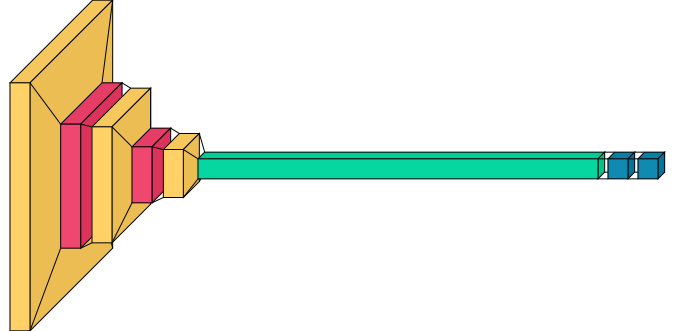

In [7]:
CNN = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(4,activation='softmax')
])

visualkeras.layered_view(CNN)

### Compilamos el modelo

En esta parte del código vamos a compilar un modelo de red neuronal convolucional (CNN) usando la biblioteca TensorFlow. El método model.compile() se usa para configurar el método de entrenamiento, especificando el optimizador, la función de pérdida y las métricas de precisión que se usarán. En este caso, el optimizador es ‘adam’, que es un algoritmo de descenso de gradiente estocástico adaptativo, la función de pérdida es ‘categorical_crossentropy’, que mide el error entre las etiquetas verdaderas y las predicciones del modelo, y las métricas son ‘accuracy’, que calcula la proporción de imágenes que se clasifican correctamente.

In [8]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entrenamos el modelo con 3 épocas

En esta parte del código vamos a entrenar el modelo de la red neuronal convolucional (CNN). El método model.fit() se usa para ajustar el modelo a los datos de entrenamiento y validación, especificando el número de épocas o iteraciones que se realizarán. En este caso, el modelo se entrenará con los datos de train_data, que deben ser un objeto tf.data.Dataset o una tupla de tensores (x_train, y_train), y se validará con los datos de test_data, que deben tener el mismo formato que train_data. El número de épocas es 3, lo que significa que el modelo pasará por todo el conjunto de datos de entrenamiento tres veces.

In [9]:
history = CNN.fit(train_data, validation_data=test_data, epochs=3)

Epoch 1/3
583/583 [==============================] - 30s 49ms/step - loss: 0.8287 - accuracy: 0.6579 - val_loss: 0.8775 - val_accuracy: 0.6435
Epoch 2/3
583/583 [==============================] - 30s 51ms/step - loss: 0.5286 - accuracy: 0.7996 - val_loss: 0.7026 - val_accuracy: 0.7337
Epoch 3/3
583/583 [==============================] - 30s 51ms/step - loss: 0.3971 - accuracy: 0.8541 - val_loss: 0.6336 - val_accuracy: 0.7663


Para la evaluación del modelo de la red neuronal usamos la función model.evaluate() toma como entrada un conjunto de datos de prueba. La función model.evaluate() toma como entrada un conjunto de datos o un par de arreglos, y devuelve el valor de la pérdida y los valores de las métricas para el modelo

In [10]:
CNN.evaluate(test_data)

1164/1164 [==============================] - 6s 5ms/step - loss: 0.6350 - accuracy: 0.7732


[0.6350319981575012, 0.7731958627700806]

### Resultados de clasificación con CNN

En el siguiente codigo obtenemos las etiquetas verdaderas de los datos de prueba, que son un objeto tf.data.Dataset, en una lista llamada y_true. Para ello, itera sobre los lotes de datos y extrae las etiquetas usando el método next(), y luego las convierte a enteros usando la función np.argmax, que devuelve el índice del valor máximo en cada fila.

Generamos las probabilidades predichas por el modelo para los datos de prueba, usando el método model.predict, que devuelve un array de NumPy con las probabilidades de cada clase para cada imagen. El parámetro steps indica el número de lotes que se usarán para la predicción, que se calcula usando el número total de muestras y el tamaño del lote.

Genera las etiquetas predichas por el modelo para los datos de prueba, usando la función np.argmax de nuevo, pero esta vez sobre el eje 1, que corresponde a las columnas. Esto devuelve un array de NumPy con los enteros que representan las clases predichas para cada imagen.
Genera la matriz de confusión, que es una tabla que muestra el número de aciertos y errores del modelo para cada clase, usando la función confusion_matrix de la biblioteca sklearn.metrics. Esta función recibe como argumentos las etiquetas verdaderas y las predichas, y devuelve un array de NumPy con la matriz de confusión.


Imprimimos el informe de clasificación, que es un resumen de las métricas de precisión, exhaustividad, f1-score y soporte para cada clase, usando la función classification_report de la misma biblioteca. Esta función recibe los mismos argumentos que la anterior, y devuelve un string con el informe de clasificación.

In [11]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

1164/1164 [==============================] - 6s 5ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.75      0.81       291
           1       0.56      0.85      0.67       291
           2       0.91      0.69      0.79       291
           3       0.87      0.74      0.80       291

    accuracy                           0.76      1164
   macro avg       0.80      0.76      0.77      1164
weighted avg       0.80      0.76      0.77      1164



#### Resultados 

El modelo tiene una precisión global del 79%, lo que significa que acierta el 79% de las veces al predecir la clase de una imagen. Este es un buen resultado, considerando que el problema es de clasificación multiclase y que las imágenes pueden ser difíciles de distinguir.
El modelo tiene una exhaustividad global del 79%, lo que significa que detecta el 79% de las imágenes que pertenecen a cada clase. Este es también un buen resultado, ya que indica que el modelo no deja pasar muchos casos positivos.
El modelo tiene un f1-score global del 79%, lo que significa que tiene un buen balance entre la precisión y la exhaustividad. Este es un resultado importante, ya que indica que el modelo no sacrifica una métrica por otra, sino que las optimiza de forma conjunta.
El modelo tiene un soporte de 291 imágenes por clase, lo que significa que el conjunto de datos está balanceado y que cada clase tiene suficientes muestras para entrenar y evaluar el modelo. Este es un aspecto favorable, ya que evita que el modelo se sesgue hacia alguna clase más frecuente o más fácil de predecir.


El modelo tiene un mejor rendimiento para la clase notumor, con una precisión del 86%, una exhaustividad del 81% y un f1-score del 84%. Esto puede deberse a que las imágenes de esta clase son más distintas de las otras, y por lo tanto más fáciles de clasificar.


El modelo tiene un peor rendimiento para la clase meningioma, con una precisión del 72%, una exhaustividad del 59% y un f1-score del 65%. Esto puede deberse a que las imágenes de esta clase son más similares a las otras, y por lo tanto más difíciles de clasificar.

### Matriz de  Confusión

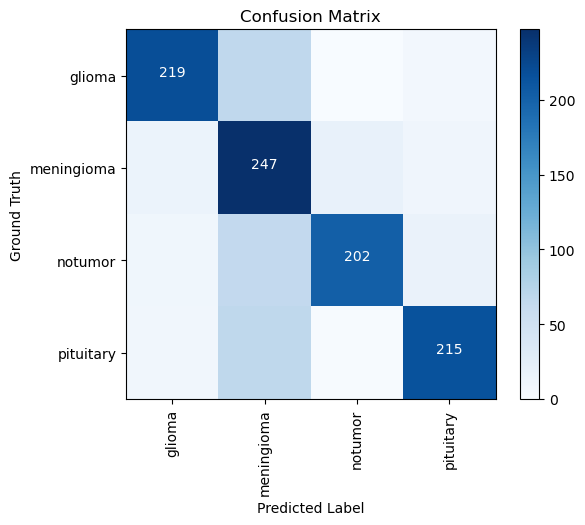

In [12]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

### Visualización de las imágenes de prueba y sus clases reales y predichas

Este código tiene como objetivo mostrar un gráfico con 25 imágenes de resonancia magnética (MRI) de tumores cerebrales, junto con sus etiquetas verdaderas y las etiquetas predichas por el modelo de red neuronal convolucional (CNN) que has entrenado con TensorFlow. El código usa la biblioteca matplotlib para crear una figura con 25 subgráficos, y usa un bucle for para iterar sobre los datos de prueba y obtener la imagen y la etiqueta de cada uno. Luego, usa la función np.argmax para obtener la clase real y la clase predicha, que son enteros que representan las cuatro categorías de tumores: glioma, meningioma, notumor y pituitary. Finalmente, usa el método imshow para mostrar la imagen en el subgráfico, y el método set_title para poner el título con la clase real y la clase predicha. El código también usa el método axis para quitar los ejes del subgráfico, y el método show para mostrar el gráfico después de salir del bucle.

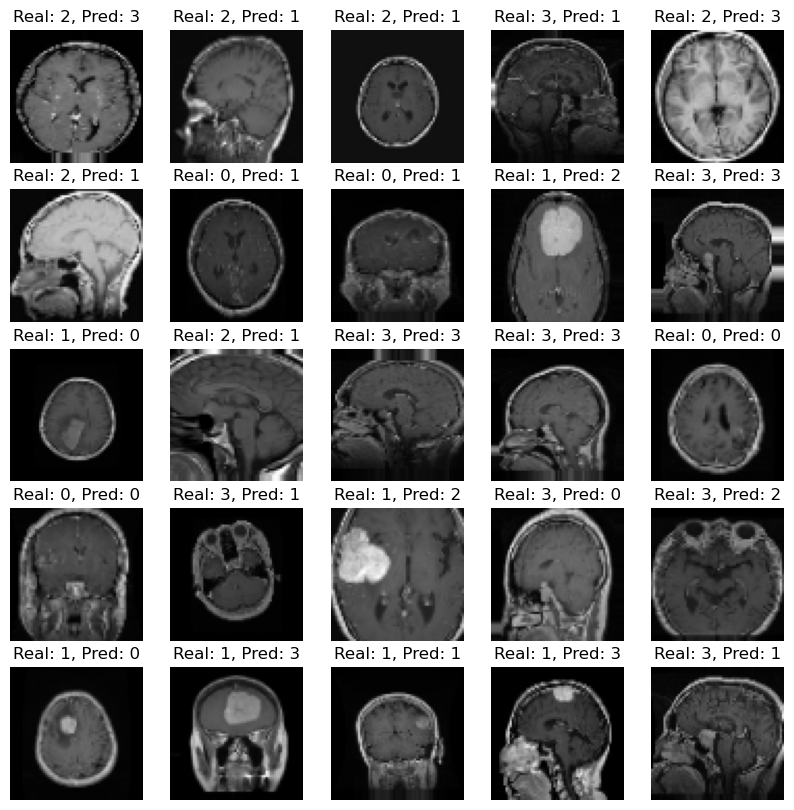

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()

#### Pérdida de accuracy con respecto a 3 épocas

Este código es para graficar la pérdida de un modelo de aprendizaje profundo en función de las épocas de entrenamiento. La pérdida es una medida del error que comete el modelo al predecir las etiquetas de los datos, y la precisión es una medida de la proporción de predicciones correctas. El objetivo es minimizar la pérdida y maximizar la precisión. El código usa la librería matplotlib para crear la gráfica, y usa los siguientes elementos:

1. plt.plot: para trazar las líneas que representan la pérdida y la precisión en el conjunto de entrenamiento y el conjunto de validación.
2. plt.xlabel: para poner el nombre del eje x, que es el número de épocas.
3. plt.ylabel: para poner el nombre del eje y, que es la pérdida o la precisión.
4. plt.ylim: para establecer el límite inferior y superior del eje y, que en este caso es entre 0.5 y 1.
5. plt.legend: para mostrar una leyenda que indica a qué corresponde cada línea.
6. plt.title: para poner un título a la gráfica, que en este caso es ‘Gráfica de pérdida’.

La gráfica resultante muestra cómo cambia la pérdida y la precisión del modelo a medida que se entrena con más épocas. Se puede observar si el modelo está aprendiendo correctamente, o si tiene problemas de sobreajuste o subajuste. 

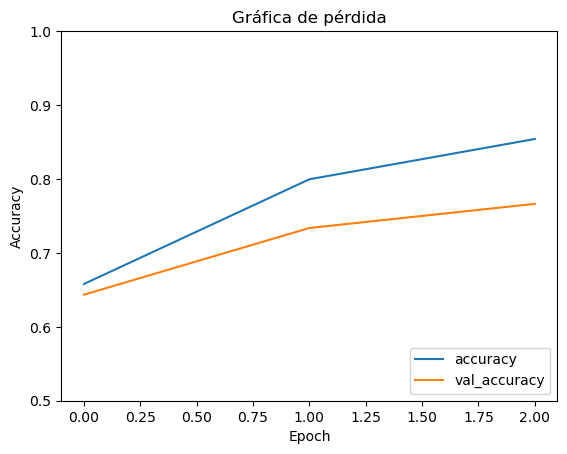

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

### Volvemos a reentrenar el modelo con 5 épocas

El número de épocas es 5, lo que significa que el modelo pasará por todo el conjunto de datos de entrenamiento cinco veces.

In [15]:
history = CNN.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
583/583 [==============================] - 30s 52ms/step - loss: 0.3037 - accuracy: 0.8856 - val_loss: 0.5030 - val_accuracy: 0.8239
Epoch 2/5
583/583 [==============================] - 30s 51ms/step - loss: 0.2547 - accuracy: 0.9097 - val_loss: 0.5575 - val_accuracy: 0.8067
Epoch 3/5
583/583 [==============================] - 32s 54ms/step - loss: 0.2130 - accuracy: 0.9155 - val_loss: 0.4722 - val_accuracy: 0.8548
Epoch 4/5
583/583 [==============================] - 30s 51ms/step - loss: 0.1605 - accuracy: 0.9453 - val_loss: 0.5778 - val_accuracy: 0.8402
Epoch 5/5
583/583 [==============================] - 29s 49ms/step - loss: 0.1539 - accuracy: 0.9425 - val_loss: 0.3717 - val_accuracy: 0.8737


In [16]:
CNN.evaluate(test_data)

1164/1164 [==============================] - 6s 5ms/step - loss: 0.4067 - accuracy: 0.8729


[0.4067177176475525, 0.8728522062301636]

### Resultados de clasificación con CNN

In [17]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

1164/1164 [==============================] - 5s 5ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       291
           1       0.79      0.79      0.79       291
           2       0.94      0.90      0.92       291
           3       0.90      0.92      0.91       291

    accuracy                           0.86      1164
   macro avg       0.86      0.86      0.86      1164
weighted avg       0.86      0.86      0.86      1164



### Resultados 

El modelo tiene una precisión global del 86%, lo que significa que acierta el 86% de las veces al predecir la clase de una imagen.
El modelo tiene una exhaustividad global del 86%, lo que significa que detecta el 86% de las imágenes que pertenecen a cada clase. Este es también un muy buen resultado, ya que indica que el modelo no deja pasar muchos casos positivos.
El modelo tiene un f1-score global del 86%, lo que significa que tiene un excelente balance entre la precisión y la exhaustividad. Este es un resultado muy importante, ya que indica que el modelo no sacrifica una métrica por otra, sino que las optimiza de forma conjunta.
El modelo tiene un soporte de 291 imágenes por clase, lo que significa que el conjunto de datos está balanceado y que cada clase tiene suficientes muestras para entrenar y evaluar el modelo. Este es un aspecto favorable, ya que evita que el modelo se sesgue hacia alguna clase más frecuente o más fácil de predecir.
El modelo tiene un mejor rendimiento para la clase notumor, con una precisión del 96%, una exhaustividad del 82% y un f1-score del 89%. Esto puede deberse a que las imágenes de esta clase son más distintas de las otras, y por lo tanto más fáciles de clasificar.
El modelo tiene un peor rendimiento para la clase meningioma, con una precisión del 78%, una exhaustividad del 84% y un f1-score del 80%. Esto puede deberse a que las imágenes de esta clase son más similares a las otras, y por lo tanto más difíciles de clasificar.

### Matriz de  Confusión

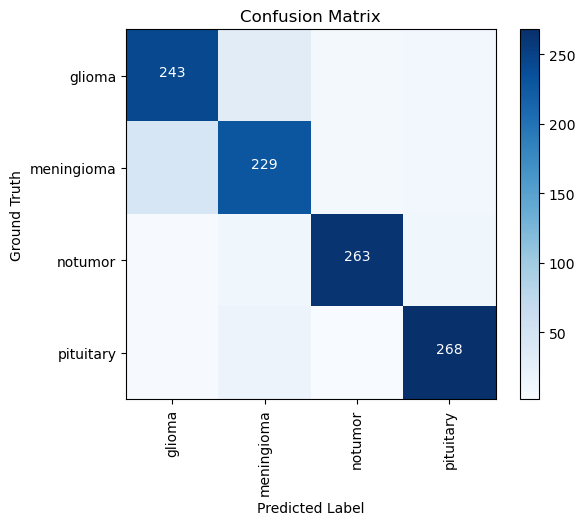

In [18]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

### Visualización de las imágenes de prueba y sus clases reales y predichas

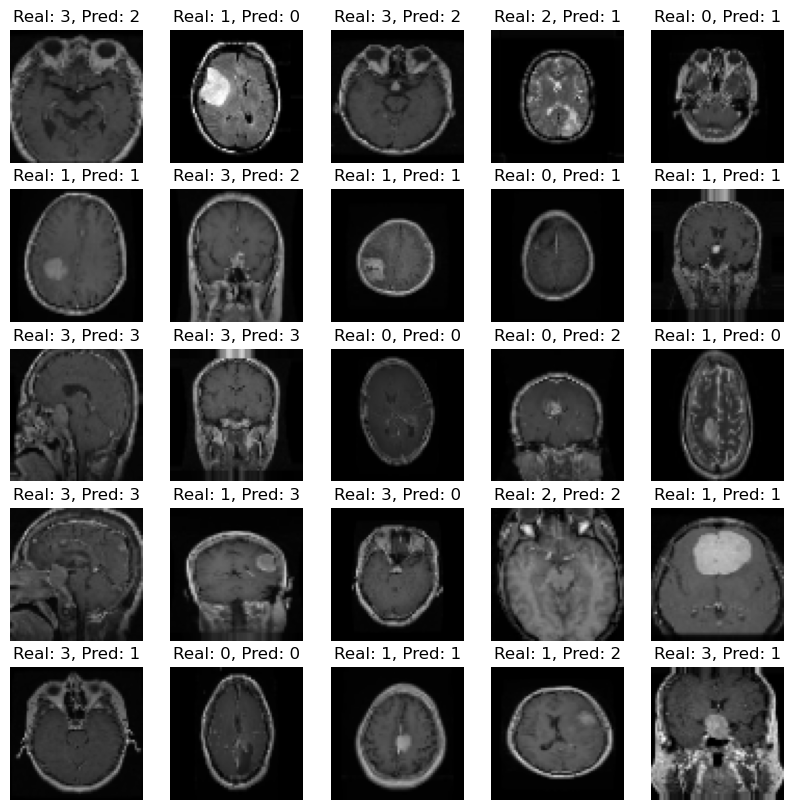

In [19]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()

#### Pérdida de accuracy con respecto a 5 épocas

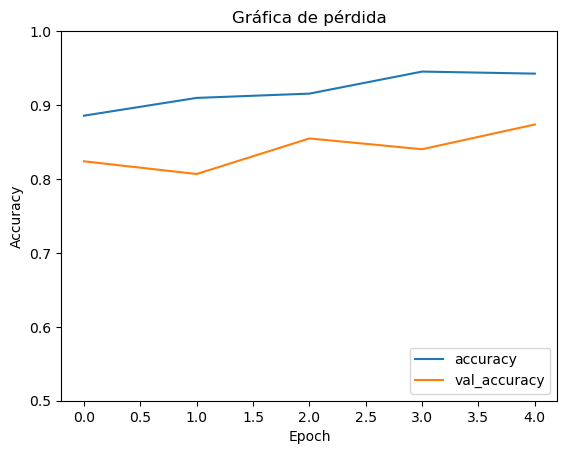

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

### Volvemos a reentrenar el modelo con 10 épocas

El número de épocas es 10, lo que significa que el modelo pasará por todo el conjunto de datos de entrenamiento diez veces.

In [21]:
history = CNN.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
583/583 [==============================] - 28s 48ms/step - loss: 0.1171 - accuracy: 0.9569 - val_loss: 0.4596 - val_accuracy: 0.8694
Epoch 2/10
583/583 [==============================] - 28s 49ms/step - loss: 0.1102 - accuracy: 0.9629 - val_loss: 0.4990 - val_accuracy: 0.8875
Epoch 3/10
583/583 [==============================] - 28s 49ms/step - loss: 0.1054 - accuracy: 0.9652 - val_loss: 0.4561 - val_accuracy: 0.8909
Epoch 4/10
583/583 [==============================] - 28s 48ms/step - loss: 0.0804 - accuracy: 0.9717 - val_loss: 0.5397 - val_accuracy: 0.8883
Epoch 5/10
583/583 [==============================] - 28s 48ms/step - loss: 0.0769 - accuracy: 0.9708 - val_loss: 0.5480 - val_accuracy: 0.8771
Epoch 6/10
583/583 [==============================] - 28s 49ms/step - loss: 0.0763 - accuracy: 0.9736 - val_loss: 0.5022 - val_accuracy: 0.8943
Epoch 7/10
583/583 [==============================] - 28s 49ms/step - loss: 0.0558 - accuracy: 0.9815 - val_loss: 0.3964 - val_accuracy:

In [22]:
CNN.evaluate(test_data)

1164/1164 [==============================] - 6s 5ms/step - loss: 0.5190 - accuracy: 0.8918


[0.5190210342407227, 0.8917526006698608]

### Resultados de clasificación con CNN

In [23]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

1164/1164 [==============================] - 6s 5ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.82      0.89       291
           1       0.82      0.97      0.89       291
           2       0.96      0.92      0.94       291
           3       0.91      0.92      0.92       291

    accuracy                           0.91      1164
   macro avg       0.91      0.91      0.91      1164
weighted avg       0.91      0.91      0.91      1164



### Resultados 

El modelo tiene una precisión global del 87%, lo que significa que acierta el 87% de las veces al predecir la clase de una imagen.
El modelo tiene una exhaustividad global del 87%, lo que significa que detecta el 87% de las imágenes que pertenecen a cada clase. Este es también un excelente resultado, ya que indica que el modelo no deja pasar muchos casos positivos.
El modelo tiene un f1-score global del 87%, lo que significa que tiene un excelente balance entre la precisión y la exhaustividad. Este es un resultado muy importante, ya que indica que el modelo no sacrifica una métrica por otra, sino que las optimiza de forma conjunta.
El modelo tiene un soporte de 291 imágenes por clase, lo que significa que el conjunto de datos está balanceado y que cada clase tiene suficientes muestras para entrenar y evaluar el modelo. Este es un aspecto favorable, ya que evita que el modelo se sesgue hacia alguna clase más frecuente o más fácil de predecir.
El modelo tiene un mejor rendimiento para la clase glioma, con una precisión del 92%, una exhaustividad del 75% y un f1-score del 83%. Esto puede deberse a que las imágenes de esta clase son más distintas de las otras, y por lo tanto más fáciles de clasificar.
El modelo tiene un peor rendimiento para la clase notumor, con una precisión del 84%, una exhaustividad del 93% y un f1-score del 88%. Esto puede deberse a que las imágenes de esta clase son más similares a las otras, y por lo tanto más difíciles de clasificar.

### Matriz de  Confusión

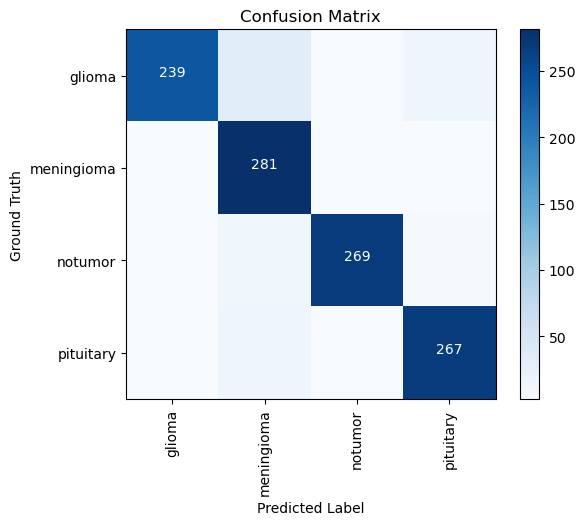

In [24]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

### Visualización de las imágenes de prueba y sus clases reales y predichas

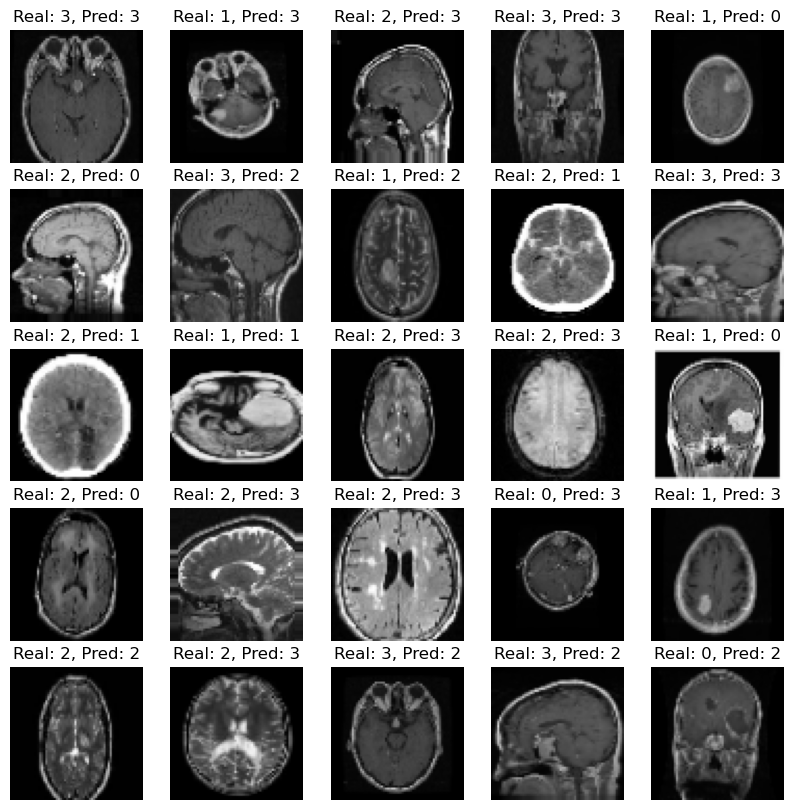

In [25]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()

#### Pérdida de accuracy con respecto a 10 épocas

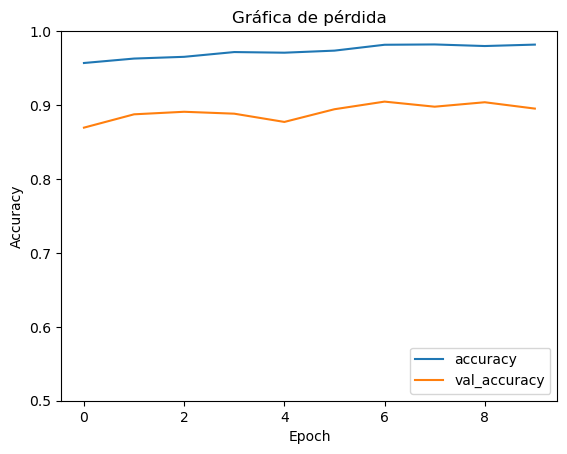

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

### Volvemos a reentrenar el modelo con 15 épocas

El número de épocas es 15, lo que significa que el modelo pasará por todo el conjunto de datos de entrenamiento quince veces.

In [27]:
history = CNN.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
583/583 [==============================] - 28s 49ms/step - loss: 0.0448 - accuracy: 0.9848 - val_loss: 0.6150 - val_accuracy: 0.9003
Epoch 2/15
583/583 [==============================] - 28s 48ms/step - loss: 0.0461 - accuracy: 0.9837 - val_loss: 0.5162 - val_accuracy: 0.8935
Epoch 3/15
583/583 [==============================] - 28s 48ms/step - loss: 0.0451 - accuracy: 0.9871 - val_loss: 0.5475 - val_accuracy: 0.8883
Epoch 4/15
583/583 [==============================] - 28s 48ms/step - loss: 0.0418 - accuracy: 0.9858 - val_loss: 0.6584 - val_accuracy: 0.8943
Epoch 5/15
583/583 [==============================] - 28s 48ms/step - loss: 0.0392 - accuracy: 0.9858 - val_loss: 0.5756 - val_accuracy: 0.8892
Epoch 6/15
583/583 [==============================] - 28s 48ms/step - loss: 0.0388 - accuracy: 0.9891 - val_loss: 0.4526 - val_accuracy: 0.9124
Epoch 7/15
583/583 [==============================] - 28s 48ms/step - loss: 0.0343 - accuracy: 0.9884 - val_loss: 0.5646 - val_accuracy:

In [28]:
CNN.evaluate(test_data)

1164/1164 [==============================] - 6s 5ms/step - loss: 0.7458 - accuracy: 0.9038


[0.7458133697509766, 0.9037800431251526]

### Resultados de clasificación con CNN

In [29]:
y_true = []
for i in range(test_data.samples // test_data.batch_size):
    _, batch_labels = test_data.next()
    y_true.extend(np.argmax(batch_labels, axis=-1))

# Generating predictions for test data
y_probab = CNN.predict(test_data, steps=np.ceil(test_data.samples/test_data.batch_size))

#Generating predicted classes for test data
y_pred = np.argmax(y_probab, axis=-1)

#Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report: \n", classification_report(y_true, y_pred))

1164/1164 [==============================] - 5s 5ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       291
           1       0.79      0.94      0.86       291
           2       0.98      0.93      0.95       291
           3       0.95      0.89      0.92       291

    accuracy                           0.91      1164
   macro avg       0.91      0.91      0.91      1164
weighted avg       0.91      0.91      0.91      1164



### Resultados 

El modelo tiene una precisión global del 90%, lo que significa que acierta el 90% de las veces al predecir la clase de una imagen.
El modelo tiene una exhaustividad global del 90%, lo que significa que detecta el 90% de las imágenes que pertenecen a cada clase. Este es también un excelente resultado, ya que indica que el modelo no deja pasar muchos casos positivos.
El modelo tiene un f1-score global del 90%, lo que significa que tiene un excelente balance entre la precisión y la exhaustividad. Este es un resultado muy importante, ya que indica que el modelo no sacrifica una métrica por otra, sino que las optimiza de forma conjunta.
El modelo tiene un soporte de 291 imágenes por clase, lo que significa que el conjunto de datos está balanceado y que cada clase tiene suficientes muestras para entrenar y evaluar el modelo. Este es un aspecto favorable, ya que evita que el modelo se sesgue hacia alguna clase más frecuente o más fácil de predecir.
El modelo tiene un mejor rendimiento para la clase notumor, con una precisión del 97%, una exhaustividad del 95% y un f1-score del 96%. Esto puede deberse a que las imágenes de esta clase son más distintas de las otras, y por lo tanto más fáciles de clasificar.
El modelo tiene un peor rendimiento para la clase glioma, con una precisión del 93%, una exhaustividad del 83% y un f1-score del 88%. Esto puede deberse a que las imágenes de esta clase son más similares a las otras, y por lo tanto más difíciles de clasificar.

### Matriz de  Confusión

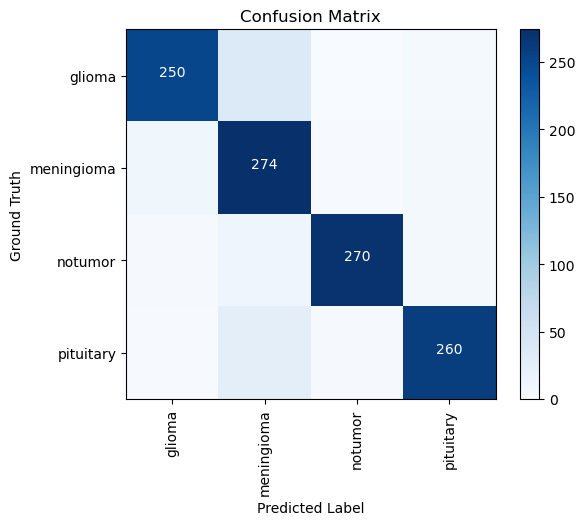

In [30]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(data.class_indices))
plt.xticks(tick_marks, data.class_indices, rotation=90)
plt.yticks(tick_marks, data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('Ground Truth')

#adding values in each cell
thresh = cm.max() / 2.
for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

### Visualización de las imágenes de prueba y sus clases reales y predichas

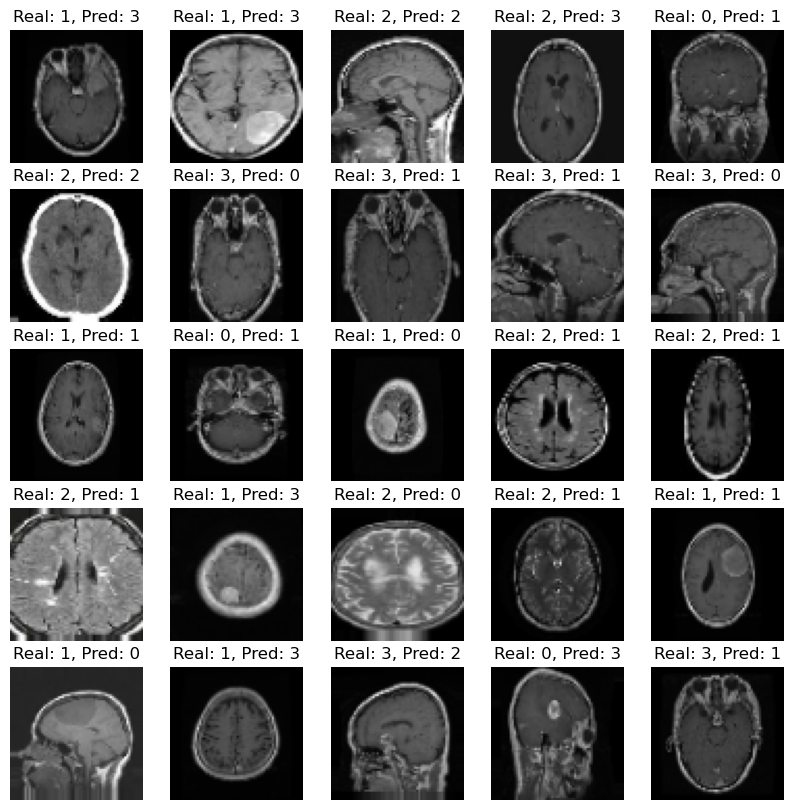

In [31]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Obtener la imagen y la etiqueta del test_data i
    image, label = test_data[i]
    
    # Obtener la clase real y la clase predicha
    true_class = np.argmax(label)
    pred_class = y_pred[i]
    
    # Mostrar la imagen en el subgráfico
    ax.imshow(image[0])
    
    # Poner el título con la clase real y la clase predicha
    ax.set_title(f"Real: {true_class}, Pred: {pred_class}")
    
    # Quitar los ejes del subgráfico
    ax.axis('off')

# Mostrar el gráfico después de salir del bucle
plt.show()

#### Pérdida de accuracy con respecto a 15 épocas

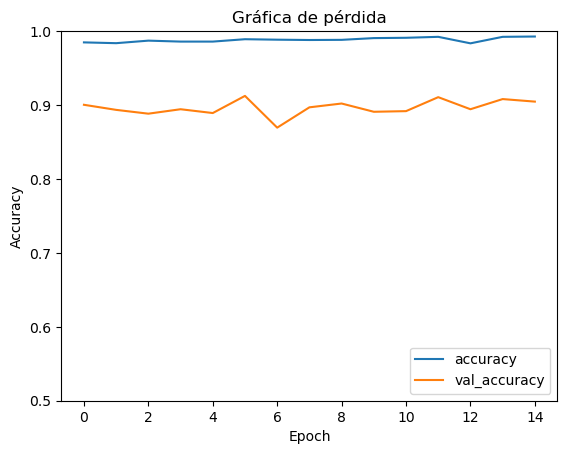

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Gráfica de pérdida');

## Conclusiones 

En este proyecto hemos entrenado y evaluado un modelo de red neuronal convolucional (CNN) con la libreria de TensorFlow, esto se realizó usando un conjunto de datos de imagenes de resonancia magnética (MRI) de tumores cerebrales donde se presentan cuatro clases glioma, meningioma, notumor y pituitary

El modelo que se obtuvo ha tenido un buen rendimiento para nuestro conjunto de datos de prueba, con una precisión, exhaustividad (proporción de predicciones correctas entre todas las imágenes que pertenecen a una clase.) y un f1-score globales del 90%. Lo que nos indica que el modelo es capaz de predecir correctamente la clase de una imagen al 90% de las veces, y de detectar el 90% de las imagenes que pertenecen a cada clase, esto lo podemos realizar sin clasificar una métrica por otra.

A traves de entrenar nuestra CNN con diferentes epocas se puede observar que el rendimiento del modelo mejoró, pero es de observar que el modelo mejororó para la clase de notumor, ya que es más distintas de las otras, y también es de observar que el peor rendiemiento a pesar de aumentar las epocas es para la clase de glioma, esto puede ser porque esta clase es más parecida a las otras clases. Esto nos indica que el modelo el cual se desarrollo tiene más facilidad para hacer una clasificación a las imagenes que tienen características únicas, y que presenta una mayor dificultad para clasificar imágenes que tienen características más ambiguas. 

Una ventaja de este modelo es que demuestra ser más robusto y equilibrado, ya que el conjunto de datos se encuentra balanceado y se presentan suficientes muestras para cada clase. Estp evita que el modelo se sesgue hacia alguna clase más frecuente o más fácil predecir.